🚀 启动 [CDFT 模型] 稳定性测试 | 目标模型: XGB
   📂 路径前缀: 'notebooks/'
   - 数据引擎: notebooks/01_feature_engineering.ipynb
   - 模型引擎: notebooks/03_final_training_xgb.ipynb

>>> 开始 10 轮压力测试 (CDFT Only)...

🔄 [Round 1/10] Injecting Seed 42 ...
   ✅ 完成! Test R2 = 0.3914

🔄 [Round 2/10] Injecting Seed 123 ...
   ✅ 完成! Test R2 = 0.4548

🔄 [Round 3/10] Injecting Seed 2024 ...
   ✅ 完成! Test R2 = -0.0734

🔄 [Round 4/10] Injecting Seed 888 ...
   ✅ 完成! Test R2 = 0.4270

🔄 [Round 5/10] Injecting Seed 666 ...
   ✅ 完成! Test R2 = 0.3938

🔄 [Round 6/10] Injecting Seed 1 ...
   ✅ 完成! Test R2 = 0.5799

🔄 [Round 7/10] Injecting Seed 7 ...
   ✅ 完成! Test R2 = 0.3751

🔄 [Round 8/10] Injecting Seed 99 ...
   ✅ 完成! Test R2 = 0.3123

🔄 [Round 9/10] Injecting Seed 100 ...
   ✅ 完成! Test R2 = 0.4516

🔄 [Round 10/10] Injecting Seed 288 ...
   ✅ 完成! Test R2 = 0.5121

📊 XGB CDFT 稳定性测试报告
   Mean R2 : 0.3825 (中心趋势)
   Std Dev : 0.1676 (波动幅度)
🖼️  美图已保存: figures\Stability_Runner_XGB_CDFT_EST.png


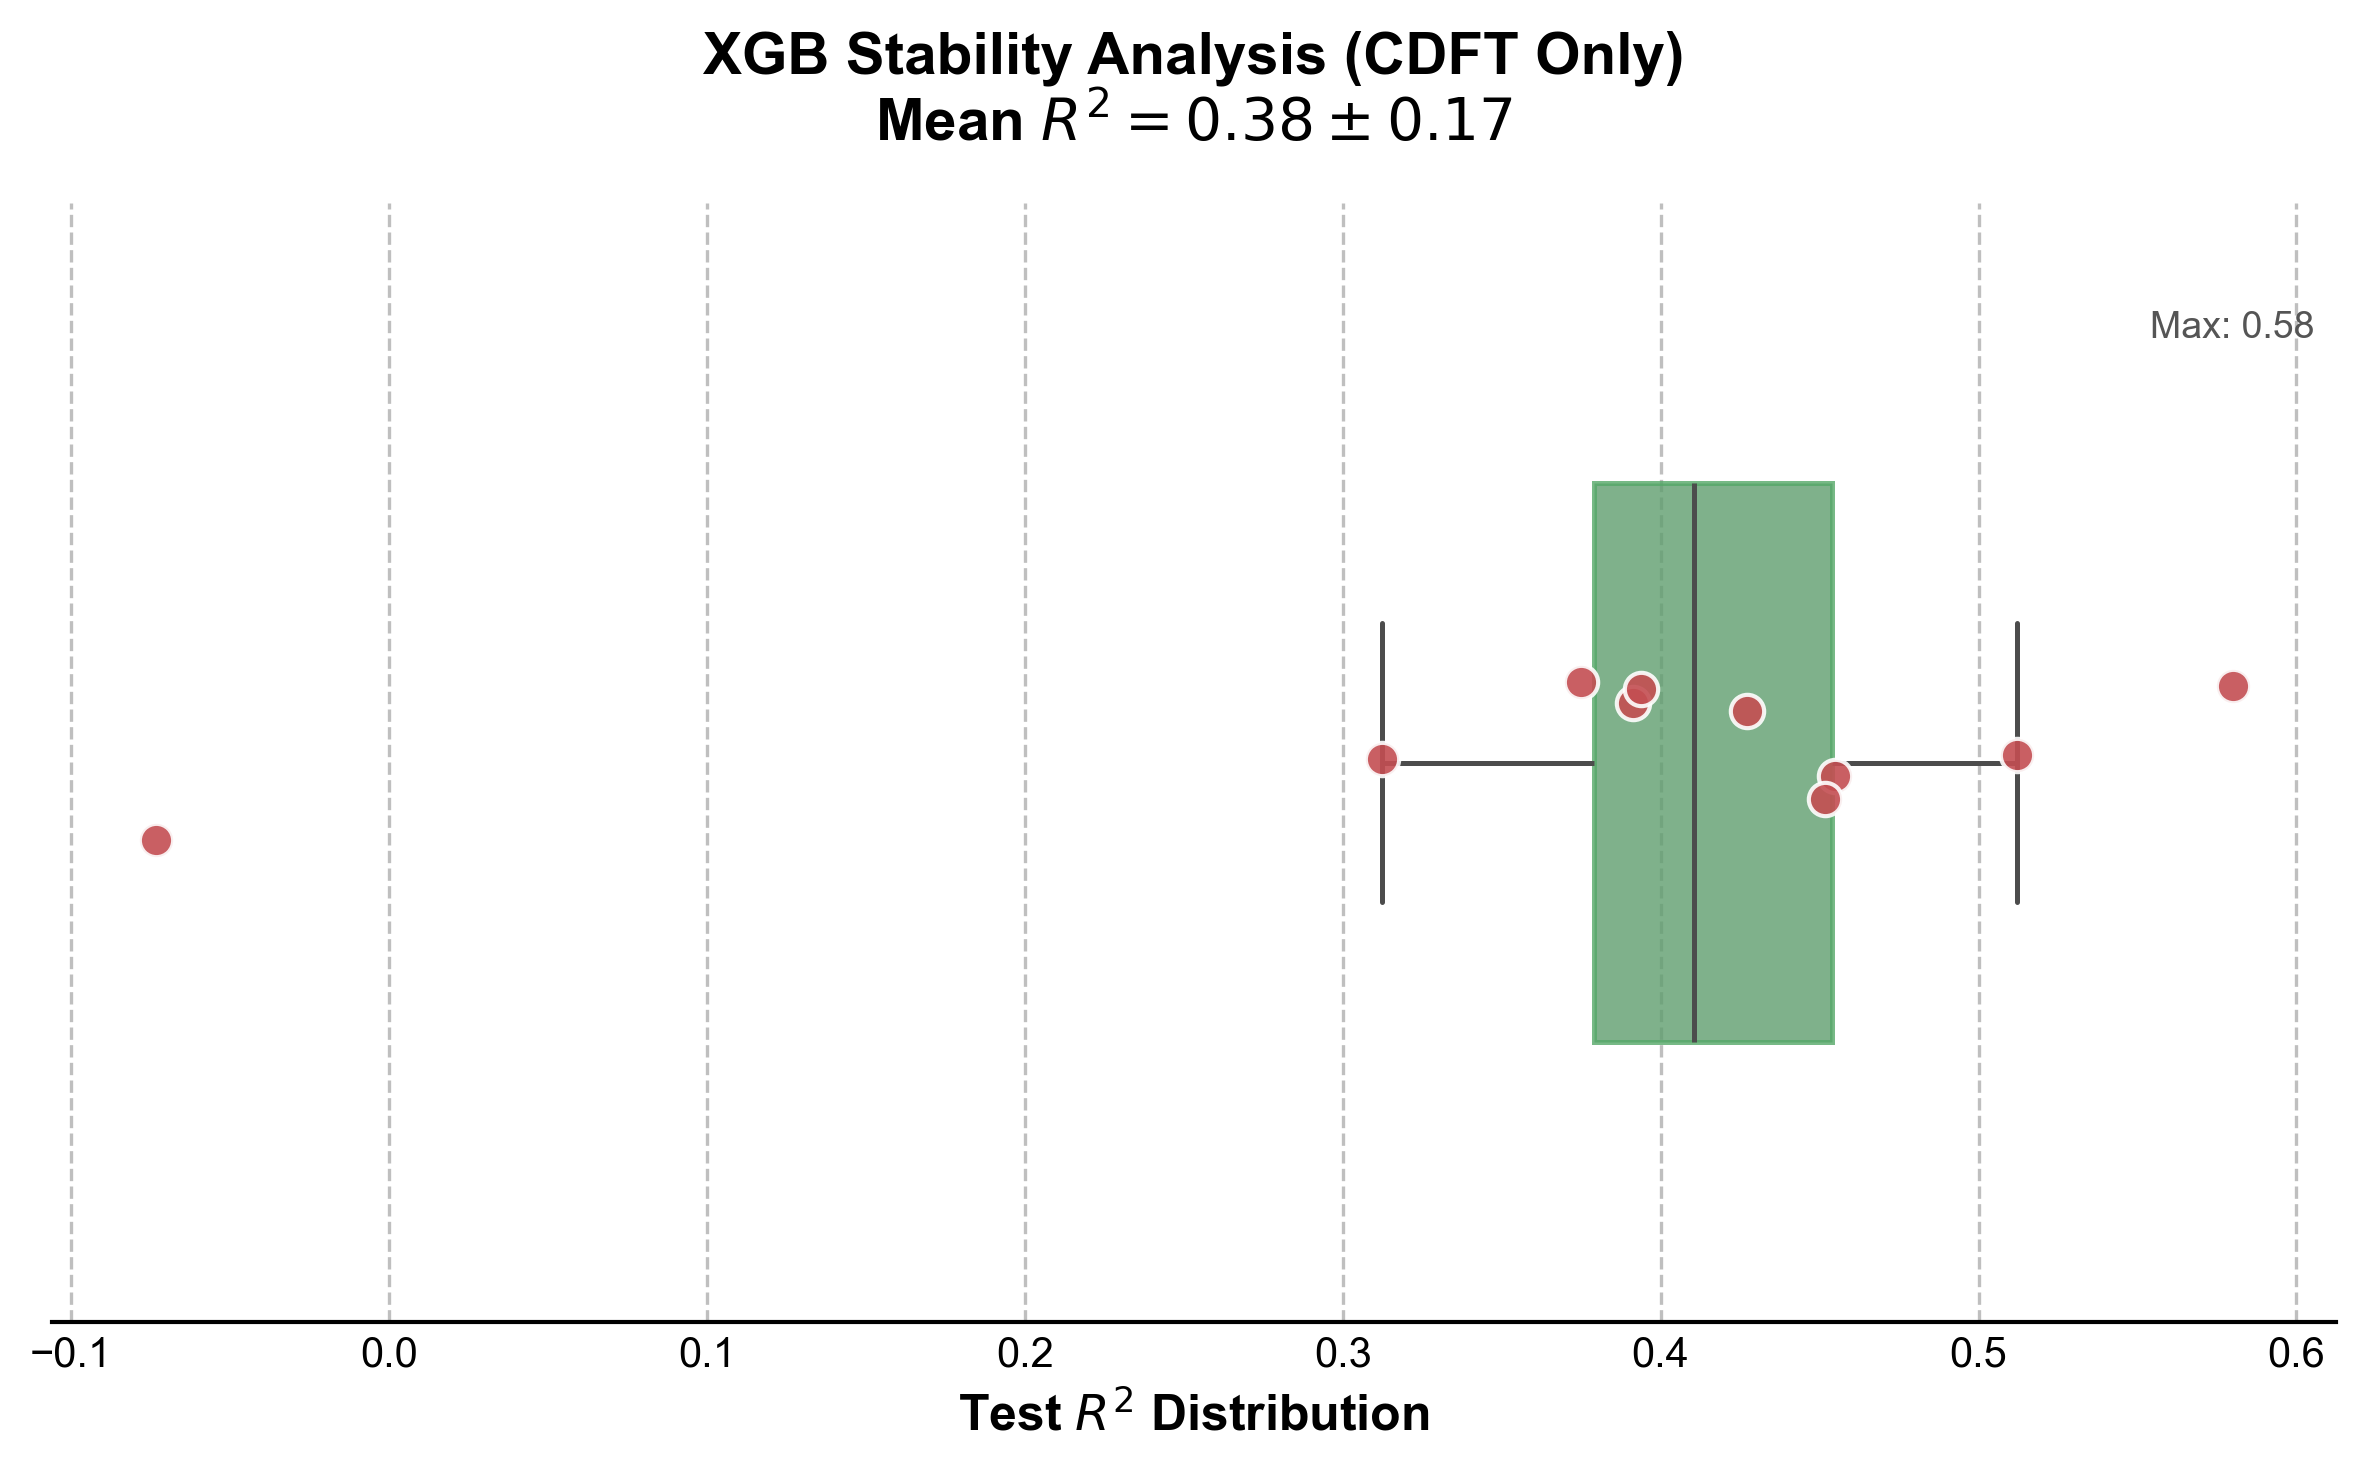

In [1]:
# ==========================================
# File: project_cdft/notebooks/05_stability_test.ipynb
# ==========================================
# [CDFT 专属版]
# 核心功能:
# 1. [指挥官模式] 远程调用 01 和 03 号文件 (Meta-Programming)
# 2. [变量控制] 仅改变 Random Seed，测试 CDFT 模型架构的鲁棒性
# 3. [视觉风格] ES&T 期刊标准: 白底 + 鼠尾草绿箱体 + 砖红散点
# 4. [智能路径] 自动识别 notebooks 路径，防止"找不到文件"

import os
import time
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ========================================================
# 🎛️ 总控台：在这里修改你要测试的模型
# ========================================================
TARGET_MODEL = "xgb"   # 选项: "xgb", "svm", "rf" ...
# ========================================================

# 1. 环境准备 & 智能路径导航
# --------------------------------------------------------
# 统一退回项目根目录视角
if 'notebooks' in os.getcwd(): os.chdir('..')
model_tag = TARGET_MODEL.lower()

# 🔍 自动侦测兵营位置 (解决路径迷路问题)
if os.path.exists("notebooks/01_feature_engineering.ipynb"):
    nb_prefix = "notebooks/"
elif os.path.exists("01_feature_engineering.ipynb"):
    nb_prefix = ""
else:
    print("❌ 严重错误: 找不到 01_feature_engineering.ipynb")
    print("   请确认您在 project_cdft 根目录下，或文件结构正确。")
    nb_prefix = ""

# 定义任务文件名 (动态构建)
task_feature = f"{nb_prefix}01_feature_engineering.ipynb"
task_model   = f"{nb_prefix}03_final_training_{model_tag}.ipynb"

# 定义配置文件和结果文件的路径
seed_config_file = "current_seed_config.txt"
pred_file = "results/predictions/final_predictions.csv"

print(f"🚀 启动 [CDFT 模型] 稳定性测试 | 目标模型: {model_tag.upper()}")
print(f"   📂 路径前缀: '{nb_prefix}'")
print(f"   - 数据引擎: {task_feature}")
print(f"   - 模型引擎: {task_model}")

# Double Check: 确保对应的 03 号文件存在
if not os.path.exists(task_model):
    raise FileNotFoundError(f"❌ 找不到模型文件: {task_model}。请先复制/创建该模型的 03 号文件。")

# ========================================================
# [Step 1] 循环调度 (The Loop)
# ========================================================
SEEDS = [42, 123, 2024, 888, 666, 1, 7, 99, 100, 288]
results = []
best_score = -999; best_seed = None

print(f"\n>>> 开始 10 轮压力测试 (CDFT Only)...")
start_total = time.time()

for i, seed in enumerate(SEEDS):
    print(f"\n🔄 [Round {i+1}/10] Injecting Seed {seed} ...")

    # 1. 写纸条 (下达种子指令)
    with open(seed_config_file, "w") as f:
        f.write(str(seed))

    # 2. 调用 01 (数据切分)
    # --inplace: 将运行结果写回原文件，方便Debug
    cmd_feat = f"jupyter nbconvert --to notebook --execute --inplace {task_feature}"
    proc_feat = subprocess.run(cmd_feat, shell=True, capture_output=True)

    if proc_feat.returncode != 0:
        print(f"❌ 01 数据工程执行失败! Seed={seed}")
        print(proc_feat.stderr.decode('utf-8', errors='ignore')[-500:])
        break

    # 3. 调用 03 (模型训练)
    cmd_model = f"jupyter nbconvert --to notebook --execute --inplace {task_model}"
    proc_model = subprocess.run(cmd_model, shell=True, capture_output=True)

    if proc_model.returncode != 0:
        print(f"❌ 03 模型训练执行失败! Model={model_tag}")
        print(proc_model.stderr.decode('utf-8', errors='ignore')[-500:])
        break

    # 4. 收作业 (读取预测结果)
    if os.path.exists(pred_file):
        try:
            df_res = pd.read_csv(pred_file)
            # 兼容列名: 'Target' 或 'Target_Log1o2'
            y_true_col = 'Target' if 'Target' in df_res.columns else 'Target_Log1o2'

            score = r2_score(df_res[y_true_col], df_res['Predicted'])
            results.append(score)

            if score > best_score: best_score = score; best_seed = seed
            print(f"   ✅ 完成! Test R2 = {score:.4f}")
        except Exception as e:
            print(f"⚠️ 读取结果出错: {e}")
            break
    else:
        print(f"❌ 致命错误：未找到预测结果文件 {pred_file}")
        break

# 打扫战场
if os.path.exists(seed_config_file): os.remove(seed_config_file)

# ========================================================
# [Step 2] 绘图 (ES&T 风格: 统一配色)
# ========================================================
if len(results) == len(SEEDS):
    results_arr = np.array(results)
    mean_r2 = np.mean(results_arr)
    std_r2 = np.std(results_arr)

    print("\n" + "="*45)
    print(f"📊 {model_tag.upper()} CDFT 稳定性测试报告")
    print(f"   Mean R2 : {mean_r2:.4f} (中心趋势)")
    print(f"   Std Dev : {std_r2:.4f} (波动幅度)")
    print("="*45)

    # 字体与背景
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- 核心配色 (与融合版 Combined 保持一致) ---
    # 鼠尾草绿 (#55A868): 箱体
    # 砖红 (#C44E52): 散点
    BOX_COLOR = '#55A868'
    POINT_COLOR = '#C44E52'

    # 绘制箱线图
    sns.boxplot(x=results, color=BOX_COLOR, width=0.5, ax=ax,
                fliersize=0, linewidth=1.2,
                boxprops=dict(alpha=0.8, edgecolor=BOX_COLOR))

    # 绘制散点图 (带白色描边)
    sns.stripplot(x=results, color=POINT_COLOR, size=8, jitter=True, ax=ax,
                  edgecolor='white', linewidth=1.0, alpha=0.9)

    # 装饰
    title_str = f'{model_tag.upper()} Stability Analysis (CDFT Only)\nMean $R^2={mean_r2:.2f} \pm {std_r2:.2f}$'
    ax.set_title(title_str, fontsize=14, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Test $R^2$ Distribution', fontsize=12, fontweight='bold', color='black')

    # 坐标轴与网格
    ax.tick_params(axis='x', colors='black', labelsize=10, direction='in')
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    for spine in ax.spines.values():
        spine.set_linewidth(1.0); spine.set_color('black')
    ax.spines['left'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    ax.set_yticks([])

    # 标注 (弱化极值，作为参考)
    ax.text(best_score, -0.38, f'Max: {best_score:.2f}',
            color='#555555', ha='center', fontsize=9, fontweight='normal')

    # 保存
    os.makedirs('figures', exist_ok=True)
    save_name = f"Stability_Runner_{model_tag.upper()}_CDFT_EST.png"
    save_path = os.path.join('figures', save_name)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"🖼️  美图已保存: {save_path}")
    plt.show()

else:
    print(f"\n⚠️ 测试未全部完成 (成功 {len(results)}/{len(SEEDS)})，跳过绘图。")
    print("   请检查上方报错信息。")